# Comp 551 Assignment 2
## Fynn Schmitt-Ulms, Joon Hwan Hong, and Daniel Korsunsky

Link to Colab Notebook:

https://colab.research.google.com/drive/1v-UOPVSPJfvTiZJ1jaj0MMxvR22YC_1a?usp=sharing

In [1]:
import itertools
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from os import listdir
from os.path import isfile, join
from scipy.sparse import csc_matrix
import itertools

In [2]:
# set random seed
np.random.seed(551)
random.seed(551)

## Some General Helper Functions

In [3]:
def create_features(train_text, test_or_val_text, min_df=10, n_gram_upper_limit=1):
    count_vect = CountVectorizer(min_df=min_df, ngram_range=(1, n_gram_upper_limit)) # Converts text into counts of each word, ignores words that occur infrequently
    tf_transformer = TfidfTransformer(use_idf=False) # Term Frequency inverse document frequency transformer
    count_vect.fit(train_text) # Only fit on the train data
    X_train, X_test_or_val = count_vect.transform(train_text), count_vect.transform(test_or_val_text)
    tf_transformer.fit(X_train)
    X_train, X_test_or_val = tf_transformer.transform(X_train), tf_transformer.transform(X_test_or_val)
    return X_train, X_test_or_val

In [4]:
def create_text_length_hist(text_data, dataset_title):
    text_lengths = np.array([len(x) for x in text_data])

    # Remove a few outliers for plotting purposes
    median = np.median(text_lengths)
    std = np.std(text_lengths)
    text_lengths = text_lengths[text_lengths < median + 2 * std]

    plt.hist(text_lengths, density=False)
    plt.xlabel("Text Lengths")
    plt.ylabel("Count")
    plt.title("Text Length Histogram of " + dataset_title)

In [5]:
def print_class_counts(labels, class_name_dict, dataset_name):
    plt.bar(class_name_dict.keys(), [(np.array(labels) == class_num).sum() for class_num in class_name_dict.values()])
    plt.xticks(rotation='vertical')
    plt.title("Class Counts for " + dataset_name)


#IMDB Data

In [6]:
def extract_text_data(main_dir, class_name_labels_dict):
    text_data = []
    text_labels = []
    for dir, label in class_name_labels_dict.items():
        file_names = [f for f in listdir(join(main_dir, dir)) if isfile(join(main_dir, dir, f))]
        for f in listdir(join(main_dir, dir)):
            potential_file = join(main_dir, dir, f)
            if isfile(potential_file):
                with open(potential_file) as f:
                    text_data.append(f.read())
                    text_labels.append(label)
    
    return text_data, np.array(text_labels)

In [7]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

# train text, train labels
train_t, train_l = extract_text_data("aclImdb/train", {"pos" : 1, "neg":0}) 
test_t, test_l = extract_text_data("aclImdb/test", {"pos" : 1, "neg":0})

print("Number of Data Points:", len(train_t))
print("Sample Label:", train_l[0])
print("Sample Data:", train_t[0], sep="\n")

--2021-03-01 02:40:29--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.1’

aclImdb_v1.tar.gz.1 100%[===================>]  80.23M  23.8MB/s    in 3.7s    

2021-03-01 02:40:33 (21.7 MB/s) - ‘aclImdb_v1.tar.gz.1’ saved [84125825/84125825]

Number of Data Points: 25000
Sample Label: 1
Sample Data:
Home Room was a great movie if you've ever had drama in your life. It keeps you wanting to see more. Wondering what the secret Alicia is hiding. I think I watched that movie 6 times in a row and never lost interest. Plus I usually don't cry over movies but this one made me cry each time. I wish I could find more movies like that one. All in All I thought it was a great movie. The more you watch of it the more you become pa

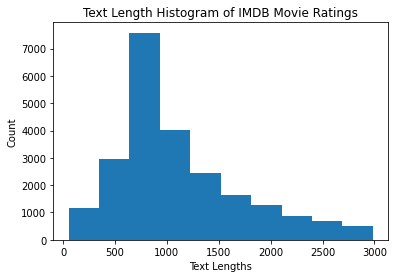

In [8]:
create_text_length_hist(train_t, "IMDB Movie Ratings")

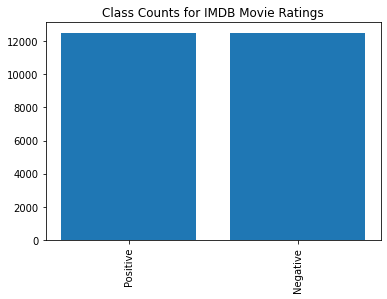

In [9]:
print_class_counts(train_l, {"Positive":1, "Negative":0}, "IMDB Movie Ratings")

# Newsgroups Data

In [10]:
train_newsgroups = fetch_20newsgroups(subset = 'train', remove=(['headers', 'footers', 'quotes']))
test_newsgroups = fetch_20newsgroups(subset = 'test', remove=(['headers', 'footers', 'quotes']))

In [11]:
print("Number of Data Points:", len(train_newsgroups.data))
print("Sample Label:", train_newsgroups.target[0])
print("Sample Data:", train_newsgroups.data[0], sep="\n")

Number of Data Points: 11314
Sample Label: 7
Sample Data:
I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


In [12]:
train_newsgroups.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

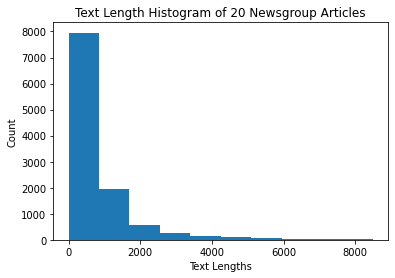

In [13]:
create_text_length_hist(train_newsgroups.data, "20 Newsgroup Articles")

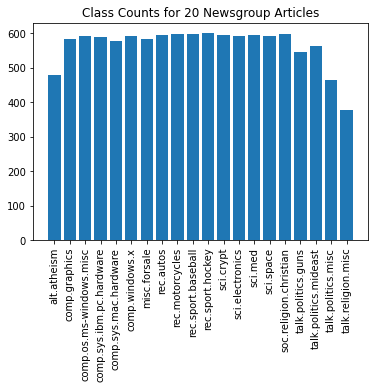

In [14]:
print_class_counts(train_newsgroups.target, dict(zip(train_newsgroups.target_names, list(range(len(train_newsgroups.target_names))))), "20 Newsgroup Articles")

# Task 2

 Naive Bayes Class

In [15]:
# NaiveBayes Extends DummyClassifier so that it can be passed as an 
# argument to scikit learn's confusion matrix function

# Using Multinomial Likelihood
class NaiveBayes(DummyClassifier):
    def __init__(self, laplace_val=1, log_correction=1e-4):
        self.laplace_val = laplace_val 
        self.log_correction = log_correction
    
    def fit(self, x, y):
        N, D = x.shape
        self.D = D
        C = np.max(y) + 1
        self.C = C

        theta = np.zeros((C, D))
        Nc = np.zeros(C)

        for c in range(C):
            x_c = x[y == c]
            Nc[c] = x_c.shape[0]
            numerator = np.sum(x_c, axis=0) + self.log_correction # Prevents features that never
            # occur in a class from messing up log values in predict function
            theta[c, :] = numerator / np.sum(numerator)
        
        self.theta = theta
        self.pi = (Nc+self.laplace_val) / (N + C*self.laplace_val)


In [16]:
def logsumexp(Z):                                                # dimension C x N
    Zmax = np.max(Z,axis=0)[None,:]                              # max over C
    log_sum_exp = Zmax + np.log(np.sum(np.exp(Z - Zmax), axis=0))
    return log_sum_exp

def predict(self, xt):
    Nt, D = xt.shape

    log_prior = np.log(self.pi)[:, None] # C x 1 (will broadcast to C x N)

    log_likelihood = np.zeros(shape=(self.C, Nt))
    # Loop through training data 
    # Can't do everything with matrix operations as the sparse matrix format doesn't
    # Allow for 3 dimensional matrices and converting to a non-sparse matrix
    # Uses more RAM than is available
    for i in range(Nt): 
        log_likelihood[:, i] = np.sum(np.multiply(xt[i, :].toarray(), np.log(self.theta)), axis=1)
    
    log_posterior = log_prior + log_likelihood
    posterior = np.exp(log_posterior - logsumexp(log_posterior))
    return np.argmax(posterior.T, 1)

NaiveBayes.predict = predict

Accuracy Evaluation

In [17]:
def evaluate_acc(true_labels, target_labels):
    return np.mean(np.array(true_labels) == np.array(target_labels))

# Task 3



K-fold cross validation


In [18]:
# Slight modification to the suggested function, this defines a cross_val split
# Using the indices of datapoints in each split instead of the splitting the 
# Dataset itself
# This allows for more flexibility later
# Also randomly shuffles the indices in the process
def cross_validation_split(n_train, k):
    ind_shuffled = np.random.permutation(n_train)
    return np.array_split(ind_shuffled, k)

In [19]:
# Also modified. We wanted to fit the preprocessing steps to the training data
# only and not also the validation sets 
# Since this is a costly operation, we perform this preprocessing once
# And then test all hyperparameter combinations on the data before moving
# on to the next train/val sets
def kfoldCV(X_text, Y, model, process_data_fun, fold_indices, hp_dict_list):
    # hp_dict_list is a dictionary mapping hyperparemter names to lists of possible values
    k = len(fold_indices)
    # Create all combinations of hyperparemeter values and iterate through them
    hyper_parameter_combs = list(itertools.product(*hp_dict_list.values()))
    val_accs = np.zeros((len(hyper_parameter_combs), k))
    for i in range(k):
        print("k=",(i+1), "/", k, sep="")
        train_indices = np.concatenate([fold_indices[j] for j in range(k) if j != i])
        # Preprocess data using Train folds and excluding Val fold
        # This prevents the tokenizers from creating tokens for words that appear in val but not in train
        # Which better represents the way the model will react to new test data
        X_train, X_val = process_data_fun([X_text[j] for j in train_indices], [X_text[j] for j in fold_indices[i]])
        Y_train, Y_val = np.array([Y[j] for j in train_indices]), np.array([Y[j] for j in fold_indices[i]])

        for j, hp_values in enumerate(hyper_parameter_combs):
            # Create model with given hyperparameters
            m = model(**dict(zip(hp_dict_list.keys(), hp_values)))

            m.fit(X_train, Y_train)
            pred = m.predict(X_val)
            val_accs[j, i] = evaluate_acc(Y_val, pred)

    avg_accs = np.mean(val_accs, 1)

    best_index = np.argmax(avg_accs)
    print("Best Val Accuracy:", avg_accs[best_index])
    for hp, hp_val in zip(hp_dict_list.keys(), hyper_parameter_combs[best_index]):
        print(hp, ": ", hp_val, sep="")
    return avg_accs

### Experiment 1

Finding optimal hyperparameters using k-fold cross validation

In [20]:
# Define a single K fold for all runs
k_fold = 5
cv_split_imdb = cross_validation_split(len(train_t), k_fold)
cv_split_20news = cross_validation_split(len(train_newsgroups.data), k_fold)

In [21]:
# Naive Bayes IMDB Data
hyperparameters = {"laplace_val":[1, 2, 3], "log_correction":[1e-3, 1e-2, 1e-1]}
avg_accs = kfoldCV(train_t, train_l, NaiveBayes, create_features, cv_split_imdb, hyperparameters)

k=1/5
k=2/5
k=3/5
k=4/5
k=5/5
Best Val Accuracy: 0.8572
laplace_val: 1
log_correction: 0.01


In [22]:
# Naive Bayes 20 Newsgroups Data
hyperparameters = {"laplace_val":[1,2, 3], "log_correction":[1e-3, 1e-2, 1e-1]}
avg_accs = kfoldCV(train_newsgroups.data, train_newsgroups.target, NaiveBayes, create_features, cv_split_20news, hyperparameters)

k=1/5
k=2/5
k=3/5
k=4/5
k=5/5
Best Val Accuracy: 0.7193746867006349
laplace_val: 2
log_correction: 0.01


In [23]:
# Logistic Regression IMDB Data
hyperparameters = {"C":[100, 10, 1, 0.1, 0.01], "n_jobs":[-1]}
avg_accs = kfoldCV(train_t, train_l, LogisticRegression, create_features, cv_split_imdb, hyperparameters)

k=1/5
k=2/5
k=3/5
k=4/5
k=5/5
Best Val Accuracy: 0.8844
C: 10
n_jobs: -1


In [24]:
# Logistic 20 Newsgroups Data
hyperparameters = {"C":[100, 10, 1, 0.1, 0.01], "n_jobs":[-1]}
avg_accs = kfoldCV(train_newsgroups.data, train_newsgroups.target, LogisticRegression, create_features, cv_split_20news, hyperparameters)

k=1/5
k=2/5
k=3/5
k=4/5
k=5/5
Best Val Accuracy: 0.6672273724112144
C: 100
n_jobs: -1


### Experiment 2
Compare performance of naive Bayes and logistic regression on each dataset

In [25]:
# Need to refit models using optimal hyperparameters from Experiment 1 on full training data
# And then report performance on test datasets
acc_list = []

# IMDb Dataset
X_imdb_train, X_imdb_test = create_features(train_t, test_t)
Y_imdb_train, Y_imdb_test = np.array(train_l), np.array(test_l)

best_imdb_naive_bayes = NaiveBayes(laplace_val= 1, log_correction= 0.01)
best_imdb_naive_bayes.fit(X_imdb_train, Y_imdb_train)
pred = best_imdb_naive_bayes.predict(X_imdb_test)
test_acc = evaluate_acc(pred, Y_imdb_test)
print("Naive Bayes IMDB:", test_acc)
acc_list.append(test_acc)

best_imdb_logistic = LogisticRegression(C=10)
best_imdb_logistic.fit(X_imdb_train, Y_imdb_train)
pred = best_imdb_logistic.predict(X_imdb_test)
test_acc = evaluate_acc(pred, Y_imdb_test)
print("Logistic Regression IMDB", test_acc)
acc_list.append(test_acc)

# 20 News Group Dataset
X_20news_train, X_20news_test = create_features(train_newsgroups.data, test_newsgroups.data)
Y_20news_train, Y_20news_test = np.array(train_newsgroups.target), np.array(test_newsgroups.target)

best_20news_naive_bayes = NaiveBayes(laplace_val= 1, log_correction= 0.01)
best_20news_naive_bayes.fit(X_20news_train, Y_20news_train)
pred = best_20news_naive_bayes.predict(X_20news_test)
test_acc = evaluate_acc(pred, Y_20news_test)
print("Naive Bayes 20 Newsgroups:", test_acc)
acc_list.append(test_acc)

best_20news_logistic = LogisticRegression(C=100)
best_20news_logistic.fit(X_20news_train, Y_20news_train)
pred = best_20news_logistic.predict(X_20news_test)
test_acc = evaluate_acc(pred, Y_20news_test)
print("Logistic Regression 20 Newsgroups:", test_acc)
acc_list.append(test_acc)

Naive Bayes IMDB: 0.83932


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression IMDB 0.8832
Naive Bayes 20 Newsgroups: 0.6686139139670738
Logistic Regression 20 Newsgroups: 0.6168348380244291


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [26]:
d = {'Accuracy': acc_list}
df = pd.DataFrame(data=d, index=['NB IMDB', 'LR IMDB', 'NB 20 Newsgroups', 'LR 20 Newsgroups'])
df

,Accuracy
NB IMDB,0.839320
LR IMDB,0.883200
NB 20 Newsgroups,0.668614
LR 20 Newsgroups,0.616835


Text(0.5, 1.0, 'Logistic Regression 20 Newsgroups Confusion Matrix')

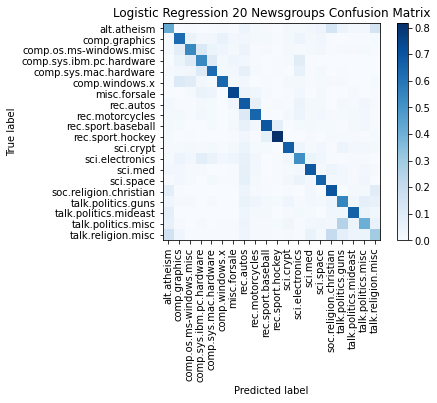

In [27]:
disp = plot_confusion_matrix(best_20news_logistic, X_20news_test, Y_20news_test, display_labels=test_newsgroups.target_names, cmap=plt.cm.Blues, include_values=False, xticks_rotation='vertical', normalize='true')
disp.ax_.set_title("Logistic Regression 20 Newsgroups Confusion Matrix")

Text(0.5, 1.0, 'Naive Bayes 20 Newsgroups Confusion Matrix')

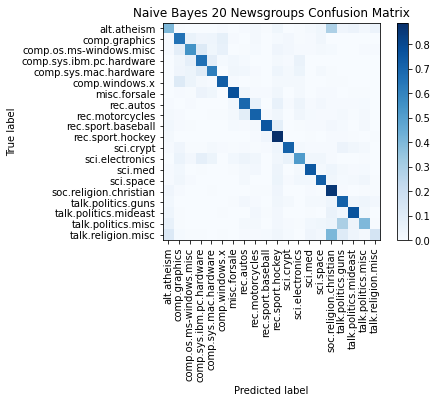

In [28]:
disp = plot_confusion_matrix(best_20news_naive_bayes, X_20news_test, Y_20news_test, 
                             display_labels=test_newsgroups.target_names, cmap=plt.cm.Blues, 
                             include_values=False, xticks_rotation='vertical', normalize='true')

disp.ax_.set_title("Naive Bayes 20 Newsgroups Confusion Matrix")

### Experiment 3
Compare accuracy of the models as a function of size of dataset

*20 NEWS GROUP DATASET*

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


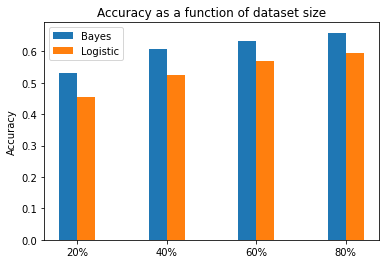

In [29]:
# **** 20 NEWS GROUP DATASET ****

# for loop variables
L = len(train_newsgroups.target)
sizes = [0.2*L, 0.4*L, 0.6*L, 0.8*L]
sizes = list(map(int, sizes)) # this also rounds
# hyperparameters 
laplace = 1 
log_corr = 1e-2
c_val = 100 
# for plotting
labels = ['20%', '40%', '60%', '80%']
label_loc = np.arange(len(labels))
width = 0.2 # arbitrary width
val_bayes = []
val_log = []

# iterate different % of train dataset, evaluate accuracy and store to list
for n in sizes:
  # get the pair-wise random n samples
  x_sample, y_sample = zip(*random.sample(list(zip(train_newsgroups.data, train_newsgroups.target)), n))
  # train and test x & y
  x_train, x_test = create_features(x_sample, test_newsgroups.data)
  y_train, y_test = np.array(y_sample), np.array(test_newsgroups.target)

  # models & their accuracy
  bayes_model = NaiveBayes(laplace_val=laplace, log_correction=log_corr)
  bayes_model.fit(x_train, y_train)
  bayes_pred = bayes_model.predict(x_test)
  bayes_accuracy = evaluate_acc(y_test, bayes_pred)

  log_model = LogisticRegression(C=c_val)
  log_model.fit(x_train, y_train)
  log_pred = log_model.predict(x_test)
  log_accuracy = evaluate_acc(y_test, log_pred)

  # record accuracy value
  val_bayes.append(bayes_accuracy)
  val_log.append(log_accuracy)

# plotting a double bar graph
fig, ax = plt.subplots()
bar1 = ax.bar(label_loc - width/2, val_bayes, width, label='Bayes')
bar2 = ax.bar(label_loc + width/2, val_log, width, label='Logistic')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy as a function of dataset size')
ax.set_xticks(label_loc)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

In [30]:
d = {'bayes accuracy': val_bayes, 'logistic accuracy': val_log}
df = pd.DataFrame(data=d, index=['20%', '40%', '60%', '80%'])
df

,bayes accuracy,logistic accuracy
20%,0.530404,0.454594
40%,0.607807,0.526022
60%,0.633431,0.569304
80%,0.659187,0.595725


*IMDb REVIEWS DATASET*

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


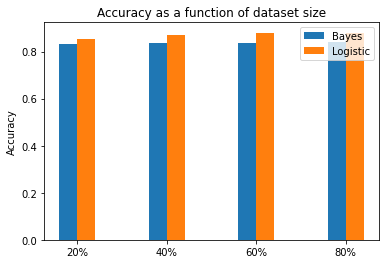

In [31]:
# **** IMDb REVIEWS DATASET ****

# for loop variables
L = len(train_t)
sizes = [0.2*L, 0.4*L, 0.6*L, 0.8*L]
sizes = list(map(int, sizes))
# hyperparameters
laplace_val = 1 
log_correction = 1e-2
c_val = 10
# for plotting
labels = ['20%', '40%', '60%', '80%']
label_loc = np.arange(len(labels))
width = 0.2 # arbitrary width
val_bayes = []
val_log = []

# iterate different % of train dataset, evaluate accuracy and store to list
for n in sizes:
  # get the pair-wise random n samples
  x_sample, y_sample = zip(*random.sample(list(zip(train_t, train_l)), n))
  # train and test x & y
  x_train, x_test  = create_features(x_sample, test_t)
  y_train, y_test = np.array(y_sample), np.array(test_l)

  # models & their accuracy
  bayes_model = NaiveBayes(laplace_val, log_correction)
  bayes_model.fit(x_train, y_train)
  bayes_pred = bayes_model.predict(x_test)
  bayes_accuracy = evaluate_acc(y_test, bayes_pred)

  log_model = LogisticRegression(C=c_val)
  log_model.fit(x_train, y_train)
  log_pred = log_model.predict(x_test)
  log_accuracy = evaluate_acc(y_test, log_pred)

  # record accuracy value 
  val_bayes.append(bayes_accuracy)
  val_log.append(log_accuracy)

# plotting a double bar graph
fig, ax = plt.subplots()
bar1 = ax.bar(label_loc - width/2, val_bayes, width, label='Bayes')
bar2 = ax.bar(label_loc + width/2, val_log, width, label='Logistic')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy as a function of dataset size')
ax.set_xticks(label_loc)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

In [32]:
d = {'bayes accuracy': val_bayes, 'logistic accuracy': val_log}
df = pd.DataFrame(data=d, index=['20%', '40%', '60%', '80%'])
df

,bayes accuracy,logistic accuracy
20%,0.83300,0.85152
40%,0.83776,0.86876
60%,0.83848,0.87692
80%,0.83992,0.88012


### Experiment 4

In [33]:
X_imdb_train, X_imdb_test = create_features(train_t, test_t, n_gram_upper_limit=2)
Y_imdb_train, Y_imdb_test = np.array(train_l), np.array(test_l)

In [34]:
X_imdb_train.shape

(25000, 80874)

In [35]:
model = NaiveBayes(laplace_val=1, log_correction=1e-2)
model.fit(X_imdb_train, Y_imdb_train)
pred = model.predict(X_imdb_test)
print("Naive Bayes IMDB with n-grams of size <= 2:", evaluate_acc(pred, Y_imdb_test))

Naive Bayes IMDB with n-grams of size <= 2: 0.87288


In [36]:
model = LogisticRegression(C=10)
model.fit(X_imdb_train, Y_imdb_train)
pred = model.predict(X_imdb_test)
print("Logistic Regression IMDB with n-grams of size <= 2:", evaluate_acc(pred, Y_imdb_test))

Logistic Regression IMDB with n-grams of size <= 2: 0.89648


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [37]:
X_20news_train, X_20news_test = create_features(train_newsgroups.data, test_newsgroups.data, n_gram_upper_limit=2)
Y_20news_train, Y_20news_test = np.array(train_newsgroups.target), np.array(test_newsgroups.target)

In [38]:
model = NaiveBayes(laplace_val=1, log_correction=1e-2)
model.fit(X_20news_train, Y_20news_train)
pred = model.predict(X_20news_test)
print("Naive Bayes 20 News groups with n-grams of size <= 2:", evaluate_acc(pred, Y_20news_test))

Naive Bayes 20 News groups with n-grams of size <= 2: 0.6463090812533192


In [39]:
model = LogisticRegression(C=100)
model.fit(X_20news_train, Y_20news_train)
pred = model.predict(X_20news_test)
print("Logistic Regression 20 News groups with n-grams of size <= 2:", evaluate_acc(pred, Y_20news_test))

Logistic Regression 20 News groups with n-grams of size <= 2: 0.6082049920339884


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Old Stuff
Modified Implementation of Gaussian Naive Bayes that works on large sparse matrices. Switched to Multinomial Likelihood for (normalized) count data


In [40]:
class GaussianNaiveBayes:
    
    def __init__(self):
        return
    
    def fit(self, x, y):
        N, D = x.shape
        C = np.max(y) + 1
        self.C = C
        # one parameter for each feature conditioned on each class
        mu, sigma = np.zeros((C,D)), np.zeros((C,D))
        Nc = np.zeros(C) # number of instances in class c
        # for each class get the MLE for the mean and std
        for c in range(C):
            x_c = x[y == c]                           #slice all the elements from class c
            Nc[c] = x_c.shape[0]                      #get number of elements of class c
            mu[c,:] = np.mean(x_c,0)                  #mean of features of class c
            sigma[c,:] = np.sqrt(np.mean(x_c.power(2), 0) - np.square(np.mean(x_c, 0)))       #std of features of class c
            # print((mu[c] == 0).sum())
            # print((sigma[c, :] == 0).sum())
            # print(x_c)
            # break
            
        self.mu = mu                                  # C x D
        self.sigma = sigma                            # C x D
        self.pi = (Nc+1)/(N+C)                        #Laplace smoothing (using alpha_c=1 for all c) you can derive using Dirichlet's distribution
        return self

In [41]:
def logsumexp(Z):                                                # dimension C x N
    Zmax = np.max(Z,axis=0)[None,:]                              # max over C
    log_sum_exp = Zmax + np.log(np.sum(np.exp(Z - Zmax), axis=0))
    return log_sum_exp

def predict(self, xt):
    Nt, D = xt.shape
    # for numerical stability we work in the log domain
    # we add a dimension because this is added to the log-likelihood matrix 
    # that assigns a likelihood for each class (C) to each test point, and so it is C x N
    log_prior = np.log(self.pi)[:, None]
    # logarithm of the likelihood term
    # the first two terms are the logarithm of the normalization term in the Gaussian and the final term is the exponent in the Gaussian. 
    # Notice that we are adding dimensions (using None) to model parameters and data to make this evaluation. 
    # The reason is that sigma and mu are C x D, while the data x is N x D. We operate on a C x N x D shape by increasing the number of dimensions when needed
    log_likelihood = np.zeros(shape=(self.C, Nt))
    for i in range(Nt):
        # print(np.log(2*np.pi))
        # print(np.log(self.sigma[:,:]))
        # print((self.sigma==0).sum())
        # print(np.log(self.sigma[:,:]).shape)
        # print(xt[i,:].toarray().shape)
        # print(self.mu[:,:].shape)
        # print(self.sigma[:,:].shape)
        # break
        # print(np.sum(-.5 * np.log(2*np.pi) - np.log(self.sigma[:,:]) -.5 * (((xt[i,:].toarray() - self.mu[:,:])/self.sigma[:,:])**2), 1))
        log_likelihood[:, i] = np.sum(-.5 * np.log(2*np.pi) - np.log(self.sigma[:,:]) -.5 * (((xt[i,:].toarray() - self.mu[:,:])/self.sigma[:,:])**2), 1)
        # print(log_likelihood[:, i])
        # break
    # log_likelihood = -.5 * np.log(2*np.pi) - np.log(self.sigma[:,None,:]) -.5 * (((xt[None,:,:] - self.mu[:,None,:])/self.sigma[:,None,:])**2)
    # now we sum over the feature dimension to get a C x N matrix (this has the log-likelihood for each class-test point combination)
    # log_likelihood = np.sum(log_likelihood, axis=2)
    # posterior calculation
    # print(log_likelihood)
    log_posterior = log_prior + log_likelihood
    posterior = np.exp(log_posterior - logsumexp(log_posterior))
    return posterior.T                                                  # dimension N x C

GaussianNaiveBayes.predict = predict